In [22]:
# Import libraries
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from rdkit.Chem import AllChem, MolFromSmiles, MACCSkeys
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor
from model_screener import ModelScreener
sns.set_style()

In [2]:
# Read data
train_data = pd.read_csv(Path("../data/train_data.csv"))
test_data = pd.read_csv(Path("../data/test_data.csv"))
train_labels = pd.read_csv(Path("../data/train_labels.csv"))
test_labels = pd.read_csv(Path("../data/test_labels.csv"))

# Screen for different fingerprints

In [6]:
# Setup functions to create fingerprints
def generate_maccs(smiles_list: list[str]) -> np.array:
    """
    Generates MACCS keys fingerprints from a list of SMILES strings.

    Parameters
    ----------
    smiles_list : list of str
        A list of SMILES (Simplified Molecular Input Line Entry System) strings representing chemical compounds.

    Returns
    -------
    np.array
        A numpy array where each element is a MACCS keys fingerprint of the corresponding SMILES string from the input list.
        Each fingerprint is a bit vector representing the presence or absence of certain chemical substructures.

    Raises
    ------
    ValueError
        If a SMILES string in the list is invalid and cannot be converted to a molecular object.
    """

    fingerprints = []
    # Convert smiles to molecule object
    for smi in smiles_list:
        mol = MolFromSmiles(smi)
        if mol is None:
            print(f"Invalid SMILES string: {smi}")
            continue
        
        # Setup fingerprint generator
        fingerprint = MACCSkeys.GenMACCSKeys(mol)
        fingerprints.append(fingerprint)
        
    return np.array(fingerprints)

def generate_ecfp4(smiles_list: list[str], radius: int = 2) -> np.array:
    """
    Generates ECFP4 fingerprints from a list of SMILES strings.

    Parameters
    ----------
    smiles_list : list of str
        A list of SMILES (Simplified Molecular Input Line Entry System) strings representing chemical compounds.
    radius : int, optional
        The radius of the circular fingerprint, default is 2. For ECFP4, the radius is typically set to 2.

    Returns
    -------
    np.array
        A numpy array where each element is an ECFP4 fingerprint of the corresponding SMILES string from the input list.
        Each fingerprint is a bit vector representing the presence or absence of certain circular substructures.

    Raises
    ------
    ValueError
        If a SMILES string in the list is invalid and cannot be converted to a molecular object.
    """
    
    fingerprints = []
    # Convert smiles to molecule objects
    for smi in smiles_list:
        mol = MolFromSmiles(smi)
        if mol is None:
            print(f"Invalid SMILES string: {smi}")
            continue
        
        # Setup fingerprint generator
        fp_generator = AllChem.GetMorganGenerator(radius=radius)
        fingerprint = fp_generator.GetFingerprintAsNumPy(mol)
        fingerprints.append(fingerprint)
        
    return np.array(fingerprints)

In [8]:
# Generate MACCS fingerprints
train_maccs = generate_maccs(train_data["SMILES"])
test_maccs = generate_maccs(test_data["SMILES"])

# Generate ECFP4 fingerprints
train_ecfp4 = generate_ecfp4(train_data["SMILES"])
test_ecfp4 = generate_ecfp4(test_data["SMILES"])

# Convert labels to numpy arrays
train_labels = np.array(train_labels).ravel()
test_labels = np.array(test_labels).ravel()

print("Shape of MACCS (train):", train_maccs.shape)
print("Shape of MACCS (test):", test_maccs.shape)
print("Shape of ECFP4 (train):", train_ecfp4.shape)
print("Shape of ECFP4 (test):", test_ecfp4.shape)
print("Shape of Solubility Values (train):", train_labels.shape)
print("Shape of Solubility Values (test):", test_labels.shape)

[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:06] WARNING: not removing hydrogen atom without neighbors
[14:59:07] WARNING: not removing hydrogen atom without neighbors
[14:59:07] WARNING: not r

Shape of MACCS (train): (7591, 167)
Shape of MACCS (test): (1898, 167)
Shape of ECFP4 (train): (7591, 2048)
Shape of ECFP4 (test): (1898, 2048)
Shape of Solubility Values (train): (7591,)
Shape of Solubility Values (test): (1898,)


[14:59:14] WARNING: not removing hydrogen atom without neighbors


Screen for different models using MACCS

In [9]:
# Create a dictionary of regression models
regression_models = {
    "dummy": DummyRegressor(),
    'linear_regression': LinearRegression(),
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'knn_regression': KNeighborsRegressor(),
    'mlp_regression': MLPRegressor(random_state=42),
}

# Set up screening object for regression
regression_screener = ModelScreener(
    x_train=train_maccs,
    y_train=train_labels,
    models=regression_models,
    metrics="neg_root_mean_squared_error",
    cv=3)

# Perform screening for regression
regression_screener.screen_models()
# Transform results into dataframe
regression_screener.transform_to_df()
results = regression_screener.results_df
# Convert negative RMSE to absolute values
results = results.assign(score_mean=results.loc[:, "score_mean"].abs())

/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

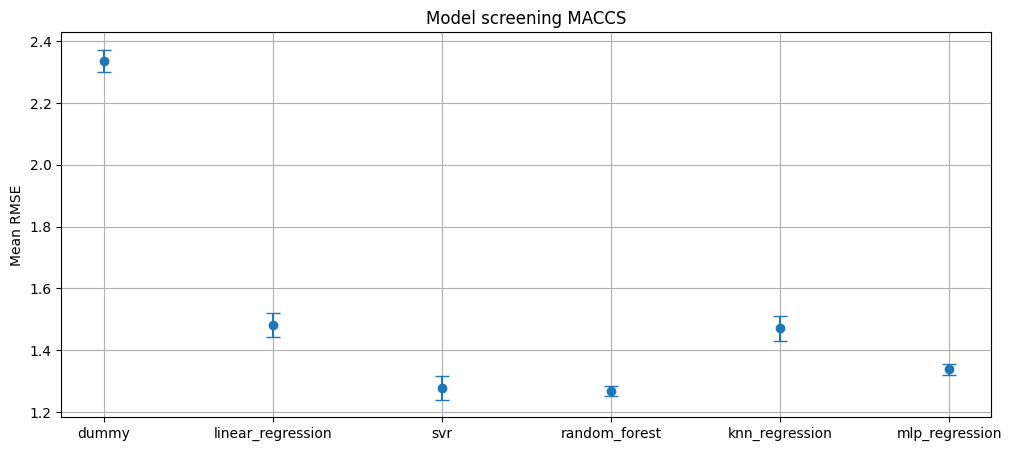

In [10]:
# Plot results
plt.figure(figsize=(12,5))
plt.errorbar(results.index, results['score_mean'], yerr=results['score_stdev'], fmt='o', capsize=5)
plt.ylabel("Mean RMSE")
plt.title("Model screening MACCS")
plt.grid(True)
plt.show()

Screen for models using ECFP4

In [11]:
# Create a dictionary of regression models
regression_models = {
    "dummy": DummyRegressor(),
    'linear_regression': LinearRegression(),
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'knn_regression': KNeighborsRegressor(),
    'mlp_regression': MLPRegressor(random_state=42),
}

# Set up screening object for regression
regression_screener = ModelScreener(
    x_train=train_ecfp4,
    y_train=train_labels,
    models=regression_models,
    metrics="neg_root_mean_squared_error",
    cv=3)

# Perform screening for regression
regression_screener.screen_models()
# Transform results into dataframe
regression_screener.transform_to_df()
results = regression_screener.results_df
# Convert negative RMSE to absolute values
results = results.assign(score_mean=results.loc[:, "score_mean"].abs())

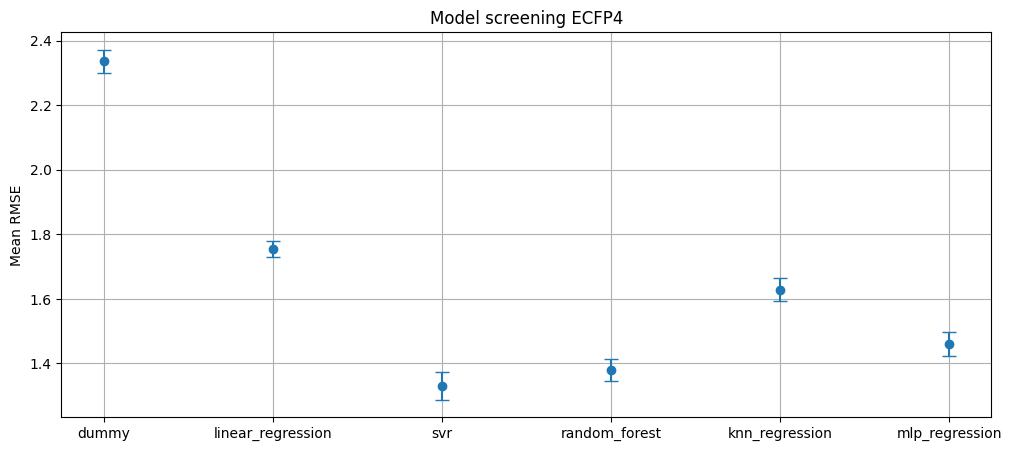

In [12]:
# Plot results
plt.figure(figsize=(12,5))
plt.errorbar(results.index, results['score_mean'], yerr=results['score_stdev'], fmt='o', capsize=5)
plt.ylabel("Mean RMSE")
plt.title("Model screening ECFP4")
plt.grid(True)
plt.show()

# Fine-Tuning

In [13]:
# Define hyperparameter space for GradientBoosting Regressor
gb_params = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

# Perform random search for GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor()
gb_random_search = RandomizedSearchCV(
    gb_regressor, param_distributions=gb_params,
    n_iter=50, cv=3, scoring='neg_root_mean_squared_error',
    verbose=1, n_jobs=-1, random_state=42)
gb_random_search.fit(train_maccs, train_labels)

#--------------------------------------------------------------

# Define hyperparameter space for SVR
svr_params = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}

# Perform random search for SVR
svr_regressor = SVR()
svr_random_search = RandomizedSearchCV(
    svr_regressor, param_distributions=svr_params, n_iter=50,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error',
    random_state=42)
svr_random_search.fit(train_maccs, train_labels)

#--------------------------------------------------------------

# Define hyperparameter space for Random Forest Regressor
forest_params = {
    "n_estimators": randint(10, 500),
    "max_depth": randint(1, 50),
    "min_samples_split": randint(3, 30)
}

# Perform random search for Forest Regressor
forest_regressor = RandomForestRegressor()
forest_random_search = RandomizedSearchCV(
    forest_regressor, param_distributions=forest_params, n_iter=50,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error',
    random_state=42)
forest_random_search.fit(train_maccs, train_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe88ea85910>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe885b58ec0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe900fc3aa0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [14]:
# Access the best hyperparameters, best models and best scores
best_gb_params = gb_random_search.best_params_
best_gb_model = gb_random_search.best_estimator_
best_gb_score = gb_random_search.best_score_

best_svr_params = svr_random_search.best_params_
best_svr_model = svr_random_search.best_estimator_
best_svr_score = svr_random_search.best_score_

best_forest_params = forest_random_search.best_params_
best_forest_model = forest_random_search.best_estimator_
best_forest_score = forest_random_search.best_score_

# Create dataframe
fine_tuning_df = pd.DataFrame(
    data=[
        [best_gb_params, abs(best_gb_score)],
        [best_svr_params, abs(best_svr_score)],
        [best_forest_params, abs(best_forest_score)],
        ],
    columns=["Best params", "Best score"],
    index=["GB", "SVR", "Random Forest"])
fine_tuning_df

,Best params,Best score
GB,"{'learning_rate': 0.1284644554526709, 'max_dep...",1.200571
SVR,"{'C': 3.954165025399161, 'gamma': 0.1}",1.204560
Random Forest,"{'max_depth': 21, 'min_samples_split': 3, 'n_e...",1.263924


In [15]:
# Save best models
filepath_gb = Path("../models/gb_maccs.pkl")
filepath_svr = Path("../models/svr_maccs.pkl")

joblib.dump(best_gb_model, filepath_gb)
joblib.dump(best_svr_model, filepath_svr)

['../models/svr_maccs.pkl']

# Combine descriptors and MACCS fingerprints

In [18]:
# Read data
train_data = pd.read_csv(Path("../data/train_data.csv"))
test_data = pd.read_csv(Path("../data/test_data.csv"))
train_labels = pd.read_csv(Path("../data/train_labels.csv"))
test_labels = pd.read_csv(Path("../data/test_labels.csv"))

# Columns of interest for 2D descriptors
descriptor_columns = [
    "MolWt", "MolLogP", "MolMR", "HeavyAtomCount", "NumHDonors",
    "NumRotatableBonds", "NumValenceElectrons", "NumAromaticRings", 
    "LabuteASA", "BertzCT", "C", "Cl", "Na", "Br", "F", "K", "O"
    ]

# Extract descriptors
train_descriptors = train_data.loc[:, descriptor_columns]
test_descriptors = test_data.loc[:, descriptor_columns]

# Generate MACCS fingerprints
train_maccs = generate_maccs(train_data["SMILES"])
test_maccs = generate_maccs(test_data["SMILES"])

# Combine descriptors and fingerprints in one array
train_combined = np.concatenate((train_descriptors.values, train_maccs), axis=1)
test_combined = np.concatenate((test_descriptors.values, test_maccs), axis=1)

# Convert labels to numpy arrays
train_labels = np.array(train_labels).ravel()
test_labels = np.array(test_labels).ravel()

print("Shape of train data:", train_combined.shape)
print("Shape of test data:", test_combined.shape)
print("Shape of Solubility Values (train):", train_labels.shape)
print("Shape of Solubility Values (test):", test_labels.shape)

[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:28] WARNING: not removing hydrogen atom without neighbors
[15:41:29] WARNING: not removing hydrogen atom without neighbors
[15:41:29] WARNING: not r

Shape of train data: (7591, 184)
Shape of test data: (1898, 184)
Shape of Solubility Values (train): (7591,)
Shape of Solubility Values (test): (1898,)


Best models were SVR, GB and MLP for separated datasets.

In [19]:
# Define hyperparameter space for GradientBoosting Regressor
gb_params = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

# Perform random search for GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor()
gb_random_search = RandomizedSearchCV(
    gb_regressor, param_distributions=gb_params,
    n_iter=50, cv=3, scoring='neg_root_mean_squared_error',
    verbose=1, n_jobs=-1, random_state=42)
gb_random_search.fit(train_combined, train_labels)

#--------------------------------------------------------------

# Define hyperparameter space for SVR
svr_params = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}

# Perform random search for SVR
svr_regressor = SVR()
svr_random_search = RandomizedSearchCV(
    svr_regressor, param_distributions=svr_params, n_iter=50,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error',
    random_state=42)
svr_random_search.fit(train_combined, train_labels)

#--------------------------------------------------------------

# Define hyperparameter space for MLPRegressor
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25), (50, 50, 50, 50, 50)],
    'activation': ['relu', 'tanh'],
    "solver": ["adam", "sgd"],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': randint(100, 1000),
    "early_stopping": [True]
}

# Perform random search for MLP
mlp_regressor = MLPRegressor()
mlp_random_search = RandomizedSearchCV(
    mlp_regressor, param_distributions=mlp_params, n_iter=50,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error',
    random_state=42)
mlp_random_search.fit(train_combined, train_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (289) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reac

RandomizedSearchCV(cv=3, estimator=MLPRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'early_stopping': [True],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50),
                                                               (100, 50, 25),
                                                               (50, 50, 50, 50,
                                                                50)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe8bb305eb0>,
                                        'solver': ['adam', 'sgd']},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [20]:
# Access the best hyperparameters, best models and best scores
best_gb_params = gb_random_search.best_params_
best_gb_model = gb_random_search.best_estimator_
best_gb_score = gb_random_search.best_score_

best_svr_params = svr_random_search.best_params_
best_svr_model = svr_random_search.best_estimator_
best_svr_score = svr_random_search.best_score_

best_mlp_params = mlp_random_search.best_params_
best_mlp_model = mlp_random_search.best_estimator_
best_mlp_score = mlp_random_search.best_score_

# Create dataframe
fine_tuning_df = pd.DataFrame(
    data=[
        [best_gb_params, abs(best_gb_score)],
        [best_svr_params, abs(best_svr_score)],
        [best_mlp_params, abs(best_mlp_score)],
        ],
    columns=["Best params", "Best score"],
    index=["GB", "SVR", "MLP"])
fine_tuning_df

,Best params,Best score
GB,"{'learning_rate': 0.12236203565420874, 'max_de...",0.980794
SVR,"{'C': 3.062735057040824, 'gamma': 'scale'}",0.947978
MLP,"{'activation': 'tanh', 'early_stopping': True,...",0.984456


In [24]:
# Save SVR model
filepath_svr = Path("../models/svr_desc_maccs.pkl")
joblib.dump(best_svr_model, filepath_svr)

['../models/svr_desc_maccs.pkl']

Combine models to voting regressor

In [23]:
# Setup estimator list
estimators=[("gb", best_gb_model), ("svr", best_svr_model), ("mlp", best_mlp_model)]

# Setup voting regressor
voting_regressor = VotingRegressor(
    estimators=estimators,
    n_jobs=-1
)

voting_regressor.fit(train_combined, train_labels)

# Calculate scores
voting_scores = cross_val_score(
    estimator=voting_regressor, 
    X=train_combined, 
    y=train_labels,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1
    )

print(f"Voting regressor RMSE mean {voting_scores.mean(): .2f} +/- {voting_scores.std(): .2f}")

Voting regressor RMSE mean -0.92 +/-  0.03


In [25]:
# Save voting regressor
filepath_voting = Path("../models/voting_desc_maccs.pkl")
joblib.dump(best_svr_model, filepath_voting)

['../models/voting_desc_maccs.pkl']

# Evaluate models on test set

In [ ]:
# Load models
gb_maccs = joblib.load("../models/gb_maccs.pkl")
svr_maccs = joblib.load("../models/svr_maccs.pkl")
svr_desc_maccs = joblib.load("../models/svr_desc_maccs.pkl")
voting_desc_maccs = joblib.load("../models/voting_desc_maccs.pkl")

In [ ]:
# Compare performances of all maccs-only models on test set
models_maccs = {
    "GB Regressor": gb_maccs,
    "SVR": svr_maccs
}

model_results = {}
for model_name, model in models_maccs.items():
    predictions = model.predict(test_maccs)
    rmse_score = root_mean_squared_error(y_pred=predictions, y_true=test_labels)
    model_results[model_name] = rmse_score
    
# Compare performances of all descriptor + maccs models on test set
models_desc_maccs = {
    "SVR (Descriptor + MACCS)": svr_desc_maccs,
    "Voting regressor (Descriptors + MACCS)" : voting_desc_maccs
}

for model_name, model in models_desc_maccs.items():
    predictions = model.predict(test_combined)
    rmse_score = root_mean_squared_error(y_pred=predictions, y_true=test_labels)
    model_results[model_name] = rmse_score

for model, score in model_results.items():
    print(f"{model}: {score:.2f}")

In [ ]:
# Plot results
sns.set_style("whitegrid")
sns.scatterplot(data=model_results, s=100, )
plt.ylabel("RMSE on solubility")
plt.title("Model performance on test set")
plt.show()

# Error analysis


In [ ]:
# Get predictions of voting classifier
voting_predictions = voting_regressor.predict(X_test_cont)
# Create dataframe for error analysis
error_analysis_df = X_test_cont.assign(
    solubility=y_test_cont,
    prediction=voting_predictions)
# Add residuals
error_analysis_df = error_analysis_df.assign(
    residual=error_analysis_df["solubility"] - error_analysis_df["prediction"])
# Extract name and smiles from original dataset
name_and_smiles = dataset.iloc[error_analysis_df.index, ].loc[:, ["Name", "SMILES"]]
error_analysis_df = error_analysis_df.assign(
    name=name_and_smiles.loc[:, "Name"],
    smiles=name_and_smiles.loc[:, "SMILES"]
)

error_analysis_df